<a href="https://colab.research.google.com/github/kengustafson/DeepDive-DataScience/blob/main/Copy_of_Capstone_Project_Cohort_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import pandas as pd
import requests
import urllib.parse
#!pip install nrel-pysam
import pickle
import os, sys
import re
import matplotlib.pyplot as plt

In [ ]:
from google.colab import auth
auth.authenticate_user()
project_id = 'numeric-melody-308801'
%load_ext google.cloud.bigquery
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://numeric-melody-308801.appspot.com/


In [3]:
def pred_wind_power(windspeed_df, power_curve):
    """Accepts dataframe with windspeeds (floats) at a certain location, Series with power produced at defined speeds.
    Returns DataFrame of 'Month' (1-12), output power ('kW'), in whatever timeframe submitted
    (eg. hourly, monthly, etc), assuming single 2MW turbine.
    Dependent on power_curve indexes equalling defined windspeed levels, and proper curve-class passed."""

    max_curve_speed = max(power_curve.index)
    windspeed = windspeed_df['wind speed at 100m (m/s)']

    lower_ws = windspeed.apply(int).apply(lambda s: s if s < max_curve_speed else 0).values
    upper_ws = lower_ws+1
    power_diff = power_curve.iloc[upper_ws].reset_index(drop=True).sub(power_curve.iloc[lower_ws].reset_index(drop=True))
    frac_power = power_diff.mul(windspeed.sub(windspeed.apply(int)))
    final_power = frac_power.add(power_curve.iloc[lower_ws].reset_index(drop=True)).rename('kW')

    return pd.concat([windspeed_df, final_power], axis=1)


In [4]:
def pred_wind_power2(windspeed_df, power_curve, temp_df, pressure_df):
    """Accepts dataframe with windspeeds (floats) at a certain location, Series with power produced at defined speeds.
    Returns DataFrame of 'Month' (1-12), output power ('kW'), in whatever timeframe submitted
    (eg. hourly, monthly, etc), assuming single 2MW turbine.
    Dependent on power_curve indexes equalling defined windspeed levels, and proper curve-class passed.
    Using equation: density = (pressure Pa)/(dry air gas constant J/kg*K)(temp K)
    """

    max_curve_speed = max(power_curve.index)
    windspeed = windspeed_df['wind speed at 100m (m/s)']
    temp = temp_df['air temperature at 100m (C)'] + 273.15  # Convert to kelvin
    pressure = pressure_df['air pressure at 100m (Pa)']

    STP = 1.225  # kg/m^3
    Ro = 287.05

    density = pressure.div(temp.mul(Ro)).div(STP)
    #density = d.mul(0.003*(pressure_df['Month']-6.5)**2 + 1)

    lower_ws = windspeed.apply(int).apply(lambda s: s if s < max_curve_speed else 0).values
    upper_ws = lower_ws+1
    power_diff = power_curve.iloc[upper_ws].reset_index(drop=True).sub(power_curve.iloc[lower_ws].reset_index(drop=True))
    frac_power = power_diff.mul(windspeed.sub(windspeed.apply(int)))
    final_power = frac_power.add(power_curve.iloc[lower_ws].reset_index(drop=True))
    power_density = final_power.mul(density).rename('kW')

    return pd.concat([windspeed_df, power_density], axis=1)

In [73]:
def pred_solar_power(solar_df, station_rated_output):
    """Accepts dataframe with Global Horizontal Irradiance (floats) at a certain location assuming in W/m^2,
    Scaler indicating output of plant in MW.
    Internal conversion factor of 200 W/m^2 used.
    ?Returns DataFrame of 'Month' (1-12), output power ('MW'), in whatever timeframe submitted
    ?(eg. hourly, monthly, etc), assuming single 1 m^2 panel.
    ?Dependent on power_curve indexes equalling defined windspeed levels, and proper curve-class passed."""

    ghi = solar_df['GHI']   # GHI in W/m^2

    pred_power = ghi.div(1000).mul(station_rated_output).rename('MW')

    return pd.concat([solar_df['Month'], pred_power], axis=1)


In [6]:
directory = '/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/test/'

## BigQuery

In [ ]:
%%bigquery --project $project_id bqdf
SELECT 
  COUNT(*) as total_rows
FROM `numeric-melody-308801.nm_winds_100m.test`

In [ ]:
bqdf

## Wind Data

In [ ]:
wind_url = 'https://developer.nrel.gov/api/wind-toolkit/v2/wind/wtk-download.json?api_key=0WIF3emAV5iUrIyfYwk0Fcm5wUZGfwLVOlLD7Nc1'
#params_state  = '&wkt=POLYGON((-103.072391+36.940417%2C-109.014299+36.966740%2C-109.011065+32.066178%2C-103.128003+32.061526%2C-103.072391+36.940417))'
params_north   = '&wkt=POLYGON((-103.072391+36.98%2C-109.014299+36.98%2C-109.007507+35.7%2C-103.131484+35.7%2C-103.072391+36.98))'

#params_upper   = '&wkt=POLYGON((-103.131484+35.7%2C-109.007507+35.7%2C-109.007507+34.45%2C-103.131484+34.45%2C-103.131484+35.7))'
params_upper_north   = '&wkt=POLYGON((-103.131484+35.705%2C-109.007507+35.705%2C-109.007507+35.07%2C-103.131484+35.07%2C-103.131484+35.705))'
params_upper_south   = '&wkt=POLYGON((-103.131484+35.705%2C-109.007507+35.705%2C-109.007507+34.45%2C-103.131484+34.45%2C-103.131484+35.705))'

params_lower   = '&wkt=POLYGON((-103.131484+34.45%2C-109.007507+34.45%2C-109.007507+33.20%2C-103.131484+33.20%2C-103.131484+34.45))'
params_south   = '&wkt=POLYGON((-103.131484+33.20%2C-109.007507+33.20%2C-109.011065+32.066178%2C-103.128003+32.061526%2C-103.131484+33.20))'

attributes = '&attributes=windspeed_100m&names=2014&utc=false&leap_day=false&interval=60&email=kengustafson@gmail.com'
# upper_south for 2013 - see if no errors
#wind_res = requests.get(wind_url + params_upper_south + attributes)

content = {}

if wind_res.status_code == 200:
    print(wind_res.headers['content-type'])

    content = wind_res.content

else:
    print('ERROR')

In [ ]:
wind_res.json()

In [ ]:
# Download data to local variable, then save to file

#nrel_res = requests.get('https://mapfiles.nrel.gov/data/wind/8ff95fad8f70284017c655f7e41e2de4.zip')
content = {}
if nrel_res.status_code == 200:
    print(nrel_res.headers['content-type'])
    content = nrel_res.content
else:
    print('ERROR')

In [ ]:
# Open a file
filepath = directory+'8ff95fad8f70284017c655f7e41e2de4.zip'
fd = os.open(filepath, os.O_CREAT|os.O_RDWR)

# Write contents
os.write(fd, content)

# Close file
os.close( fd )

In [15]:
# Get data at a POINT

wind_url = 'https://developer.nrel.gov/api/wind-toolkit/v2/wind/wtk-download.json?api_key=0WIF3emAV5iUrIyfYwk0Fcm5wUZGfwLVOlLD7Nc1'
params_point   = '&wkt=POINT(-103.285278+32.952778)'
wind_attributes = '&attributes=windspeed_100m&names=2014&utc=false&leap_day=false&interval=60&email=kengustafson@gmail.com'
temp_attributes = '&attributes=temperature_100m&names=2014&utc=false&leap_day=false&interval=60&email=kengustafson@gmail.com'
pressure_attributes = '&attributes=pressure_100m&names=2014&utc=false&leap_day=false&interval=60&email=kengustafson@gmail.com'
all_attributes = '&attributes=windspeed_100m,temperature_100m,pressure_100m&names=2014&utc=false&leap_day=false&interval=60&email=kengustafson@gmail.com'

point_res = requests.get(wind_url + params_point + wind_attributes)

content = {}
if point_res.status_code == 200:
    print(point_res.headers['content-type'])
    content = point_res.content
else:
    print('ERROR')

application/json; charset=utf-8


In [16]:
point_res.json()['outputs']['downloadUrl']

'https://mapfiles.nrel.gov/data/wind/033fab00318253e60090b4ff03abb810.zip'

## -Modify wind files; add lat/lng columns-

In [ ]:
files = os.listdir(path=directory + '17d32a62f10464f6ae3841d2026ec8cd/')

for file in files:
    id, lat, lng, year = file.split('_')
    #lat = file[7:12]
    #lng = file[13:20]
    df = pd.read_csv(directory + '17d32a62f10464f6ae3841d2026ec8cd/' + file, header=1)
    df['latitude'] = lat
    df['longitude'] = lng

    df['datetime'] = pd.to_datetime(
        df['Year'].apply(str)+'-'+
        df['Month'].apply(str)+'-'+
        df['Day'].apply(str)+' '+
        df['Hour'].apply(str)+':'+
        df['Minute'].apply(str)+':00', infer_datetime_format=True)
    
    df.rename(columns={'wind speed at 100m (m/s)':'windspeed'}, inplace=True)
    df.drop(labels=['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)

    df.to_csv('/content/sample_data/' + '17d32a62f10464f6ae3841d2026ec8cd/' + file, index=False)

In [ ]:
df = pd.read_csv('/content/sample_data/' + '17d32a62f10464f6ae3841d2026ec8cd/' + files[0])
df

In [ ]:
# Copy files to Google Cloud Storage, for subsequent import into BigQuery

bucket = 'gs://numeric-melody-308801.appspot.com/'
source = '/content/sample_data/17d32a62f10464f6ae3841d2026ec8cd/*' #/8234b812172692f28e758302e6c7b2b0/9*'
!gsutil -m cp {source} {bucket}

In [ ]:
#!gsutil ls gs://numeric-melody-308801.appspot.com
#!gsutil -m rm gs://numeric-melody-308801.appspot.com/*

In [ ]:
"""
for VARIABLE in $(gsutil ls)
do
  echo $(gsutil du $VARIABLE | grep -v /$ | wc -l) $VARIABLE
done
"""

## Site Count

In [ ]:
sites_url = 'https://developer.nrel.gov/api/nsrdb/v2/site-count.json?api_key=0WIF3emAV5iUrIyfYwk0Fcm5wUZGfwLVOlLD7Nc1'
params = '&wkt=POLYGON((-103.072391+36.940417%2C-109.014299+36.966740%2C-109.011065+32.066178%2C-103.128003+32.061526%2C-103.072391+36.940417))'

#sites_res = requests.get(sites_url + params)

content = {}

if sites_res.status_code == 200:
    print(sites_res.headers['content-type'])

    content = sites_res.content

else:
    print('ERROR')

In [ ]:
sites_res.json()

## Wind Wind Plants

In [291]:
power_plants = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/Power_Plants.csv')
power_plants_nm = power_plants[power_plants['State']=='New Mexico'].copy()
power_plants_nm.drop(labels=['X', 'Y', 'OBJECTID', 'Code', 'Sector_Name', 'State', 'Zip',
       'Street_Address', 'PrimSource', 'Coal_MW',
       'NG_MW', 'Crude_MW', 'Hydro_MW', 'HydroPS_MW', 'Nuclear_MW', 'Solar_MW',
       'Data_Source', 'Geoth_MW', 'Battery_MW', 'Others_MW', 'Biomass_MW'], axis=1, inplace=True)
power_plants_nm.reset_index(inplace=True, drop=True)
power_curves = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/wind_power_curves.csv')


In [ ]:
power_plants_nm

In [ ]:
power_curves

## Estimate Wind Plant Outputs

In [ ]:
#'C1 > 8.5; 7.5 < C2 < 8.5; C3 < 7.5'

In [293]:
pickle_data = pickle.load(open('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data Sets/dict_wind_data_m.p','rb'))

monthly_wind_actual = pd.DataFrame.from_dict(pickle_data)

In [ ]:
monthly_wind_actual

####**NM Wind Energy Center**

In [322]:
nm_wec = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/nm-wec.csv', header=1)
nm_wec_temp = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/nm-wec-temp.csv', header=1)
nm_wec_pressure = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/nm-wec-pressure.csv', header=1)

In [323]:
nm_wec['wind speed at 100m (m/s)'].mean()   # Indicates Class_2 turbines

7.9022168949771805

In [325]:
pred_wind_power(nm_wec, power_curves['Class_2'])['kW'].sum() * 102/1000

792599.16408

In [328]:
pred_wind_power2(nm_wec, power_curves['Class_2'], nm_wec_temp, nm_wec_pressure)['kW'].sum() * 102/1000

661043.9606251057

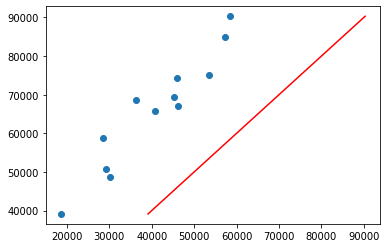

In [330]:
pred_pwr = pred_wind_power(nm_wec, power_curves['Class_2']).groupby('Month').sum().reset_index(drop=True)['kW'] * 102/1000
act_pwr = monthly_wind_actual[monthly_wind_actual['Year']=='2014']['NM Wind MWH'].sort_index(ascending=False).reset_index(drop=True)

plt.scatter(act_pwr, pred_pwr)
plt.plot([min(pred_pwr), max(pred_pwr)], [min(pred_pwr), max(pred_pwr)], c='red')

In [ ]:
act_pwr / pred_pwr

In [332]:
pred_pwr2 = pred_wind_power2(nm_wec, power_curves['Class_2'], nm_wec_temp, nm_wec_pressure).groupby('Month').sum().reset_index(drop=True)['kW'] * 102/1000

act_pwr / pred_pwr2

0     0.829827
1     0.763905
2     0.800863
3     0.776604
4     0.759381
5     0.767378
6     0.597607
7     0.586969
8     0.697582
9     0.742204
10    0.808859
11    0.615185
dtype: float64

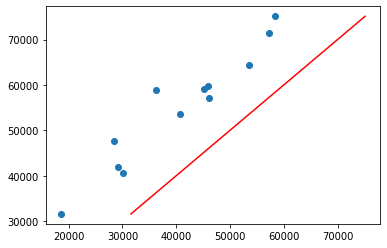

In [334]:
plt.scatter(act_pwr, pred_pwr2)
plt.plot([min(pred_pwr2), max(pred_pwr2)], [min(pred_pwr2), max(pred_pwr2)], c='red')

####**Caprock**

In [335]:
caprock = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/caprock.csv', header=1)
caprock['wind speed at 100m (m/s)'].mean()   # Indicates Class_1 turbines

9.301796803652971

In [336]:
pred_wind_power(caprock, power_curves['Class_1'])['kW'].sum() * 40/1000

369286.66848

In [337]:
pred_pwr = pred_wind_power(caprock, power_curves['Class_1']).groupby('Month').sum().reset_index(drop=True)['kW'] * 40/1000

act_pwr = monthly_wind_actual[monthly_wind_actual['Year']=='2014']['Caprock MWH'].sort_index(ascending=False).reset_index(drop=True)

act_pwr - pred_pwr

0    -4225.66248
1    -9797.01768
2    -3294.17552
3    -4632.89192
4    -1968.19416
5    -1679.19032
6    -7598.75864
7    -3256.13544
8    -3069.41888
9    -2511.55808
10   -4432.64704
11   -6141.01832
dtype: float64

####**San Juan**

In [ ]:
san_juan = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/san_juan.csv', header=1)
san_juan['wind speed at 100m (m/s)'].mean()   # Indicates Class_2 turbines

In [ ]:
pred_wind_power(san_juan, power_curves['Class_2'])['kW'].sum() * 60/1000

In [ ]:
pred_pwr = pred_wind_power(san_juan, power_curves['Class_2']).groupby('Month').sum().reset_index(drop=True)['kW'] * 60/1000

act_pwr = monthly_wind_actual[monthly_wind_actual['Year']=='2014']['San Juan Mesa MWH'].sort_index(ascending=False).reset_index(drop=True)

act_pwr - pred_pwr

In [ ]:
act_pwr / pred_pwr

####**Red Mesa**

In [ ]:
red_mesa = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/red_mesa.csv', header=1)
red_mesa['wind speed at 100m (m/s)'].mean()   # Indicates Class_2 turbines

In [ ]:
pred_wind_power(red_mesa, power_curves['Class_2'])['kW'].sum() * 51.2/1000

####**High Lonesome**

In [ ]:
high_lonesome = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/high_lonesome.csv', header=1)
high_lonesome['wind speed at 100m (m/s)'].mean()   # Indicates Class_2 turbines

In [ ]:
pred_wind_power(high_lonesome, power_curves['Class_2'])['kW'].sum() * 50/1000

####**Aragonne**

In [ ]:
aragonne = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/aragonne.csv', header=1)
aragonne['wind speed at 100m (m/s)'].mean()   # Indicates Class_1 turbines

In [ ]:
pred_wind_power(aragonne, power_curves['Class_1'])['kW'].sum() * 45/1000

In [ ]:
pred_wind_power(aragonne, power_curves['Class_1']).groupby('Month').sum() * 45/1000

####**Macho Springs**

In [338]:
macho_springs = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/macho_springs.csv', header=1)
macho_springs_temp = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/macho-springs-temp.csv', header=1)
macho_springs_pressure = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/macho-springs-pressure.csv', header=1)

macho_springs['wind speed at 100m (m/s)'].mean()   # Indicates Class_3 turbines

6.411804794520562

In [339]:
pred_wind_power(macho_springs, power_curves['Class_3'])['kW'].sum() * 25.2/1000

147777.5785248

In [340]:
pred_wind_power2(macho_springs, power_curves['Class_3'], macho_springs_temp, macho_springs_pressure)['kW'].sum() * 25.2/1000

122072.03541784798

In [369]:
pred_pwr = pred_wind_power(macho_springs, power_curves['Class_3']).groupby('Month').sum().reset_index(drop=True)['kW'] * 25.2/1000

act_pwr = monthly_wind_actual[monthly_wind_actual['Year']=='2014']['Macho Springs MWH'].sort_index(ascending=False).reset_index(drop=True)

act_pwr / pred_pwr

0     0.755765
1     0.934287
2     0.845186
3     0.694427
4     0.687130
5     0.800066
6     0.729922
7     0.765447
8     0.833311
9     0.934105
10    0.849567
11    0.860693
dtype: float64

In [370]:
pred_wind_power2_macho = pred_wind_power2(macho_springs, power_curves['Class_3'], macho_springs_temp, macho_springs_pressure).groupby('Month').sum().reset_index(drop=True)['kW'] * 25.2/1000

act_pwr / pred_wind_power2_macho

0     0.888129
1     1.112995
2     1.011336
3     0.837552
4     0.845600
5     1.005887
6     0.911810
7     0.946376
8     1.018014
9     1.134838
10    1.008158
11    1.008928
dtype: float64

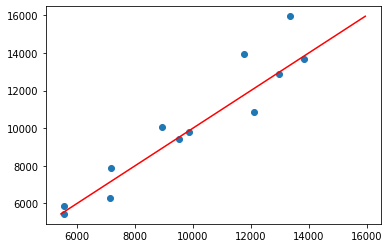

In [371]:
plt.scatter(act_pwr, pred_wind_power2_macho)
plt.plot([min(pred_wind_power2_macho), max(pred_wind_power2_macho)], [min(pred_wind_power2_macho), max(pred_wind_power2_macho)], c='red')

####**Wildcat - 2014**

In [345]:
wildcat = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/wildcat.csv', header=1)
wildcat_temp = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/wildcat-temp.csv', header=1)
wildcat_pressure = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/wildcat-pressure.csv', header=1)

wildcat['wind speed at 100m (m/s)'].mean()   # Indicates Class_3 turbines

7.499834474885824

In [346]:
pred_wind_power(wildcat, power_curves['Class_3'])['kW'].sum() * 13.65/1000

103131.7950936

In [347]:
pred_wind_power2(wildcat, power_curves['Class_S97'], wildcat_temp, wildcat_pressure)['kW'].sum() * 13/1000

105825.32200423047

In [357]:
pred_pwr = pred_wind_power(wildcat, power_curves['Class_S97']).groupby('Month').sum().reset_index(drop=True)['kW'] * 13/1000

act_pwr = monthly_wind_actual[monthly_wind_actual['Year']=='2014']['Wildcat MWH'].sort_index(ascending=False).reset_index(drop=True)

act_pwr.sum() / pred_pwr.sum()

0.7655019595103526

In [358]:
act_pwr / pred_pwr

0     0.902508
1     0.850314
2     0.859936
3     0.783264
4     0.781419
5     0.699035
6     0.567223
7     0.625872
8     0.605800
9     0.881663
10    0.867301
11    0.676146
dtype: float64

In [359]:
pred_wind_power2_wildcat = pred_wind_power2(wildcat, power_curves['Class_S97'], wildcat_temp, wildcat_pressure).groupby('Month').sum().reset_index(drop=True)['kW'] * 13/1000
print(act_pwr.sum() / pred_wind_power2_wildcat.sum())
act_pwr / pred_wind_power2_wildcat 

0.8964206127925388


0     1.023790
1     0.973463
2     0.998502
3     0.920814
4     0.933684
5     0.842733
6     0.681748
7     0.753999
8     0.715974
9     1.038034
10    0.993258
11    0.771499
dtype: float64

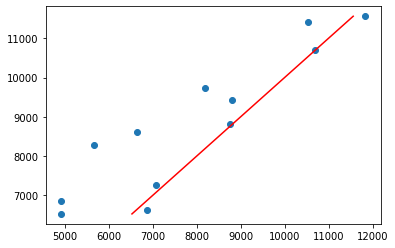

In [360]:
plt.scatter(act_pwr, pred_wind_power2_wildcat)
plt.plot([min(pred_wind_power2_wildcat), max(pred_wind_power2_wildcat)], [min(pred_wind_power2_wildcat), max(pred_wind_power2_wildcat)], c='red')

####**Wildcat 2013**

In [361]:
wildcat_2013 = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/wildcat-wind-2013.csv', header=1)
wildcat_temp_2013 = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/wildcat-temp-2013.csv', header=1)
wildcat_pressure_2013 = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/wildcat-pressure-2013.csv', header=1)

wildcat_2013['wind speed at 100m (m/s)'].mean()   # Indicates Class_3 turbines

7.648914383561674

In [362]:
pred_wind_power(wildcat_2013, power_curves['Class_3'])['kW'].sum() * 13.65/1000

108339.7171311

In [363]:
pred_wind_power2(wildcat_2013, power_curves['Class_S97'], wildcat_temp_2013, wildcat_pressure_2013)['kW'].sum() * 13/1000

111324.24018028748

In [364]:
pred_pwr = pred_wind_power(wildcat_2013, power_curves['Class_S97']).groupby('Month').sum().reset_index(drop=True)['kW'] * 13/1000

act_pwr = monthly_wind_actual[monthly_wind_actual['Year']=='2013']['Wildcat MWH'].sort_index(ascending=False).reset_index(drop=True)

act_pwr.sum() / pred_pwr.sum()

0.7112239934569946

In [365]:
act_pwr / pred_pwr

0     0.716782
1     0.815789
2     0.751048
3     0.826614
4     0.736147
5     0.660518
6     0.607662
7     0.556137
8     0.552186
9     0.766899
10    0.690047
11    0.784952
dtype: float64

In [366]:
pred_wind_power2_wildcat = pred_wind_power2(wildcat_2013, power_curves['Class_S97'], wildcat_temp_2013, wildcat_pressure_2013).groupby('Month').sum().reset_index(drop=True)['kW'] * 13/1000
act_pwr.sum() / pred_wind_power2_wildcat.sum()

0.8271424071781361

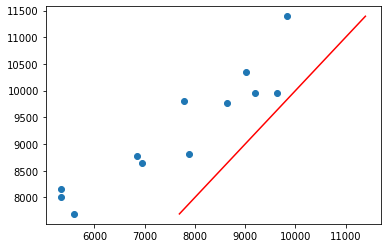

In [367]:
plt.scatter(act_pwr, pred_wind_power2_wildcat)
plt.plot([min(pred_wind_power2_wildcat), max(pred_wind_power2_wildcat)], [min(pred_wind_power2_wildcat), max(pred_wind_power2_wildcat)], c='red')

## Solar Data

In [109]:
# Get solar at a POINT

solar_url = 'https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-download.csv?api_key=0WIF3emAV5iUrIyfYwk0Fcm5wUZGfwLVOlLD7Nc1'
params_point = '&wkt=POINT(-104.633333+36.466667)'
attributes = '&attributes=dhi,dni,ghi&names=2019&utc=false&leap_day=false&interval=60&email=kengustafson@gmail.com'

point_res = requests.get(solar_url + params_point + attributes)

content = {}
if point_res.status_code == 200:
    print(point_res.headers['content-type'])
    content = point_res.content
else:
    print('ERROR')

text/csv


In [110]:
# Open file
filepath = directory + 'solar-' + params_point[5:] + '.csv'
fd = os.open(filepath, os.O_CREAT|os.O_RDWR)
# Write contents
os.write(fd, content)
# Close file
os.close( fd )

### Estimate Solar Plant Outputs

###SunE SPS5 Hopi - 2014

In [87]:
sun_hopi = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/solar-POINT(Sun_Hopi).csv', header=2)

In [ ]:
sun_hopi.head(22)

In [ ]:
pred_sun_hopi = pred_solar_power(sun_hopi, 10.1).groupby('Month').sum().reset_index()
pred_sun_hopi.head(22)

In [91]:
pickle_data = pickle.load(open('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data Sets/dict_solar_data_m.p','rb'))

monthly_solar_actual = pd.DataFrame.from_dict(pickle_data)
monthly_solar_actual[['Month', 'Year']] = monthly_solar_actual['Month'].str.split(expand=True)

In [ ]:
monthly_solar_actual

In [97]:
act_sun_hopi = monthly_solar_actual[monthly_solar_actual['Year']=='2014']['SPS5_Hopi PV MWH'].sort_index(ascending=False).reset_index(drop=True)

In [108]:
act_sun_hopi

0      693.659
1      669.590
2      838.717
3      810.539
4     1507.792
5     3347.103
6     2781.969
7     2730.214
8     2459.651
9     2610.315
10    1975.455
11    1607.996
Name: SPS5_Hopi PV MWH, dtype: float64

In [105]:
act_sun_hopi / pred_sun_hopi['MW']

0     0.581524
1     0.566783
2     0.454284
3     0.379628
4     0.609014
5     1.412824
6     1.201997
7     1.334911
8     1.692637
9     1.637357
10    1.717340
11    1.868151
dtype: float64

In [84]:
sun_hopi_2019 = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/solar-POINT(Sun_Hopi_2019).csv', header=2)

In [100]:
pred_sun_hopi_2019 = pred_solar_power(sun_hopi_2019, 10.1).groupby('Month').sum().reset_index()
pred_sun_hopi_2019.head(12)

,Month,MW
0,1,1062.7422
1,2,1253.4100
2,3,1536.5635
3,4,2083.9431
4,5,2321.0507
5,6,2431.5346
6,7,2357.2188
7,8,2147.5630
8,9,1729.4331
9,10,1553.9254


In [101]:
act_sun_hopi_2019 = monthly_solar_actual[monthly_solar_actual['Year']=='2019']['SPS5_Hopi PV MWH'].sort_index(ascending=False).reset_index(drop=True)

In [102]:
act_sun_hopi_2019

0      966.891
1     1018.813
2     1517.745
3     1786.727
4     1902.194
5     2139.610
6     2025.227
7     2061.649
8     1701.821
9     1672.813
10    1039.684
11     757.826
Name: SPS5_Hopi PV MWH, dtype: float64

In [106]:
act_sun_hopi_2019 / pred_sun_hopi_2019['MW']

0     0.909808
1     0.812833
2     0.987753
3     0.857378
4     0.819540
5     0.879942
6     0.859160
7     0.959995
8     0.984034
9     1.076508
10    1.018120
11    0.755011
dtype: float64

###Cimarron - 30 MW

In [111]:
cimarron = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/solar-POINT(Cimarron).csv', header=2)

pred_cimarron = pred_solar_power(cimarron, 30).groupby('Month').sum().reset_index()
pred_cimarron

,Month,MW
0,1,3007.44
1,2,3399.90
2,3,5220.87
3,4,5774.79
4,5,6680.13
5,6,7259.67
6,7,6256.14
7,8,6374.34
8,9,5096.13
9,10,4294.53


In [112]:
pickle_data = pickle.load(open('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data Sets/dict_solar_data_m.p','rb'))
monthly_solar_actual = pd.DataFrame.from_dict(pickle_data)
monthly_solar_actual[['Month', 'Year']] = monthly_solar_actual['Month'].str.split(expand=True)

act_cimarron = monthly_solar_actual[monthly_solar_actual['Year']=='2014']['Cimmaron PV MWH'].sort_index(ascending=False).reset_index(drop=True)
print(act_cimarron.sum())
act_cimarron #

62443.0


0     4785.0
1     4611.0
2     5790.0
3     5630.0
4     5674.0
5     6294.0
6     5265.0
7     6034.0
8     5503.0
9     5468.0
10    4037.0
11    3352.0
Name: Cimmaron PV MWH, dtype: float64

In [113]:
- pred_cimarron['MW']

0    -3007.44
1    -3399.90
2    -5220.87
3    -5774.79
4    -6680.13
5    -7259.67
6    -6256.14
7    -6374.34
8    -5096.13
9    -4294.53
10   -2926.68
11   -2272.53
Name: MW, dtype: float64

In [114]:
act_cimarron / pred_cimarron['MW']

0     1.591054
1     1.356216
2     1.109011
3     0.974927
4     0.849385
5     0.866982
6     0.841573
7     0.946608
8     1.079839
9     1.273248
10    1.379379
11    1.475008
dtype: float64